# Проект анализа оттока клиентов банка

## Материалы:

**Презентация:** https://disk.yandex.ru/i/FHs2cCGLq7NOCg

## Цель проекта:

Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка. 

На основании анализа, описать возможные причины оттока и предложить рекомендации для снижения негативной динамики.

## Входные данные:

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск

## Описание данных

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## План проекта:

### Этап 1. Получение данных

    - импортируем библиотеки
    - откроем файлы с данными
    - изучим общую информацию данных

### Этап 2. Предобработка данных

    - найдем и исправим ошибки
    - приведем данные к нужным типам
    - заменим/удалим/оставим пропуски

### Этап 3. Исследовательский анализ данных

- посмотрим есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения
- посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
- построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)
- построим матрицу корреляций

### Этап 4. Сегментация клиентов

Для этого:
- сгруппируем клиентов по нескольким признакам, построим графики. Сделаем выводы.
- определим признаки влияющие на отток клиентов.
- определим долю клиентов, склонных к оттоку.
- сформируем портреты групп клиентов: "лояльные", "уходящие"

### Этап 5. Проверка гипотез

Гипотезы:
- Средние доходы между клиентами, которые ушли и теми, которые остались одинаковые
- Среднее значение возраста клиентов, которые ушли и тех, которые остались одинаковое

### Этап 6. Выводы и рекомендации

## Этап 1. Получение данных

In [1]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
#загрузим данные
data = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')

In [3]:
data.head() #посмотрим на несколько строк данных

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
#посмотрим общую информацию
print('Общая информация')
data.info()
print('====================================')
print('Дубликатов в таблице:', data.duplicated().sum())
print('====================================')
print('Пропусков в таблице:')
print(data.isna().sum())
print('====================================')
print('Количество уникальных значений:')
print(data.nunique())

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
Дубликатов в таблице: 0
Пропусков в таблице:
userid                 0
score                  0
City                   0
Gender                 0
Age     

 ## Этап 2. Предобработка данных

**Исправим наименования столбцов**

In [5]:
# приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

**Разберемся с пропусками в балансах**

В столбце `balance` 3617 пропущенных значений, около 1/3 всех данных. Это много. Но удалять их не будем, слишком много потеряем.

Посмотрим на клиентов с пропуском в балансе подробнее.

Создадим столбец-копию по балансу, заменим пропуски на 'не указан', там где есть баланс - 'указан'.

In [6]:
data['balance_copy'] = data['balance'].copy()
data['balance_copy'] = data['balance_copy'].fillna('не указан')
data.loc[(data['balance_copy'] != 'не указан'), 'balance_copy'] = 'указан'

In [7]:
data.head() # проверим

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,указан
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,не указан
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,указан


Посмотрим на средние знаения и доли по признакам

In [8]:
data.groupby('balance_copy').agg('mean').T.round(2)

balance_copy,не указан,указан
userid,15734685.59,15733104.80
score,649.45,651.14
age,38.43,39.20
objects,5.07,4.98
balance,NaN,119827.49
products,1.78,1.39
creditcard,0.72,0.70
loyalty,0.52,0.51
estimated_salary,98983.56,100717.35
churn,0.14,0.24


В глаза бросается различие по количеству продуктов: у клиентов без баланса продуктов ближе к 2-м, с балансом - ближе к 1-му. Также есть разнице в процентах оттока в двух группах. Без баланса - 14%, с балансом - 24%.

In [9]:
pd.pivot_table(data,
               values=["userid"],
               index=['churn'],
               columns=["balance_copy"],
               aggfunc=['count'])

count       
                userid       
balance_copy не указан указан
churn                        
0                 3117   4846
1                  500   1537

В оттоке доля клиентов без баланса меньше 

Посмотрим ситуацию по продуктам

In [10]:
pd.pivot_table(data,
               values=["userid"],
               index=['products'],
               columns=["balance_copy"],
               aggfunc=['count'])

count       
                userid       
balance_copy не указан указан
products                     
1                  905   4179
2                 2600   1990
3                   98    168
4                   14     46

Значительно превышает доля клиентов с пропуском баланса с 2-мя продуктами

Постмотрим на гистограммы распределения долей по балансу

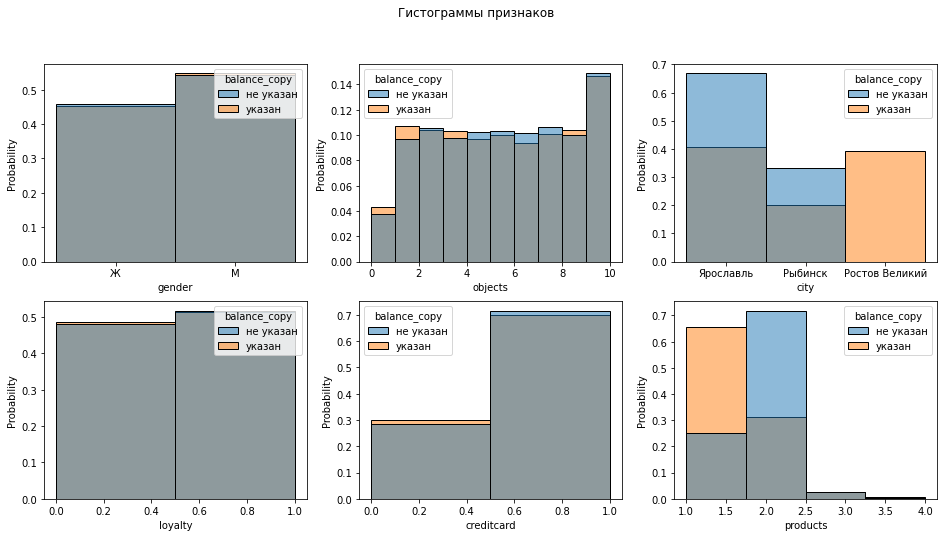

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

fig.suptitle('Гистограммы признаков')
hue = 'balance_copy'
stat="probability"
sns.histplot(ax=axes[0, 0], x='gender', stat=stat, bins=2, common_norm=False, data=data, hue = hue)
sns.histplot(ax=axes[0, 1], x='objects', stat=stat, bins=10, common_norm=False, data=data, hue = hue)
sns.histplot(ax=axes[0, 2], x='city', stat=stat, bins=3, common_norm=False, data=data, hue = hue)
sns.histplot(ax=axes[1, 0], x='loyalty', stat=stat, bins=2, common_norm=False, data=data, hue = hue)
sns.histplot(ax=axes[1, 1], x='creditcard', stat=stat, bins=2, common_norm=False, data=data, hue = hue)
sns.histplot(ax=axes[1, 2], x='products', stat=stat, bins=4, common_norm=False, data=data, hue = hue)
plt.show() 

С продуктом мы определились, по остальным параметрам более менее доли равны. Но вот по городам есть аномалия. В Ростове Великом отсутствуют клиенты с пропущенным балансом

In [12]:
pd.pivot_table(data,
               values=["userid"],
               index=['city'],
               columns=["balance_copy"],
               aggfunc=['count'])

count        
                  userid        
balance_copy   не указан  указан
city                            
Ростов Великий       NaN  2509.0
Рыбинск           1199.0  1278.0
Ярославль         2418.0  2596.0

Так и есть, в Ярославле и Рыбинске доли клиентов без баланса и с балансом равняются примерно 50 на 50, а вот в Ростове клиентов с пропусками нет совсем.

Явные причины такой аномалии нам неизвестны. Можно предположить, что в отделениях банка этого города произошел системный сбой. Чуть ниже мы рассмотрим ситуацию с оттоком в этом городе подробнее.

Посмотрим, влияет ли баланс на динамику оттока.

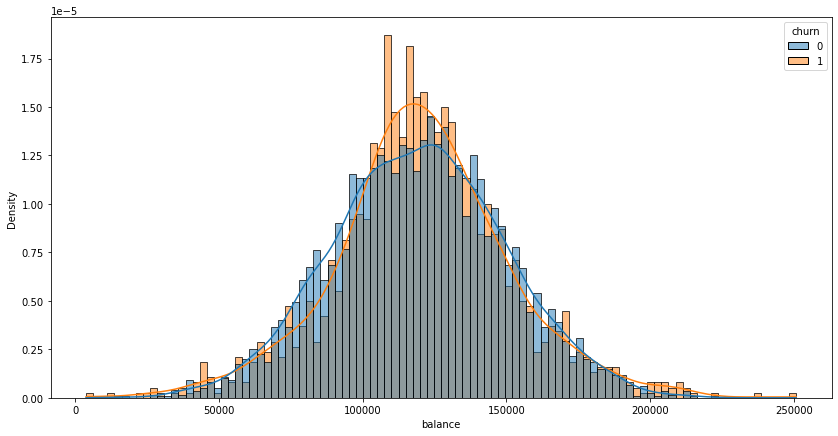

In [13]:
f, ax = plt.subplots(figsize=(14, 7))

sns.histplot(x='balance',
             stat="density",
             bins=100,
             common_norm=False,
             data=data,
             kde = True,
             hue = 'churn')
plt.show()

Значения баланса имеют нормальное распределение, перекосов и выбросов не наблюдается.  
Исходя из графика, можно сказать, что величина баланса не влияет на долю оттока. Поэтому, этим столбцом в последующих расчетах можно пренебречь, пропуски удалять либо заполнять (нулями, медианой) нет смысла.

**Перекодируем категориальные значения (город, пол)**

Воспользуемся методом *get_dummies*, чтоб не потерять столбцы, сделаем их копии.

In [14]:
# сделаем копии нужных столбцов
data['city_copy'] = data['city'].copy()
data['gender_copy'] = data['gender'].copy()

In [15]:
# перекодируем
data = pd.get_dummies(data, columns=['city_copy', 'gender_copy'])

In [16]:
data.head(2) # проверим

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,city_copy_Ростов Великий,city_copy_Рыбинск,city_copy_Ярославль,gender_copy_Ж,gender_copy_М
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан,0,0,1,1,0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан,0,1,0,1,0


Немного поправим названия новых столбцов

In [17]:
data = data.rename(columns={'city_copy_Ростов Великий': 'rostov'
                            , 'city_copy_Рыбинск': 'rybinsk'
                            , 'city_copy_Ярославль': 'yaroslavl'
                            , 'gender_copy_Ж': 'female'
                            , 'gender_copy_М': 'male'})

In [18]:
data.head(2) # проверим eщё раз

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан,0,0,1,1,0
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан,0,1,0,1,0


Перекодировка готова

Больше аномалий в датасете не обнаружено: дубликатов нет, типы соответствуют.

## Этап 3. Исследовательский анализ данных

**Посмотрим на статистические данные**

In [19]:
data.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl,female,male
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.501400,0.454300,0.545700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.500023,0.497932,0.497932
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Что видим из статистических данных?:

- средний бал кредитного скоринга - 650, данный бал у половины клиентов,
- мужчин чуть больше чем женщин - 54% клиентов,
- средний возраст клиентов - 39 лет,
- среднее количество объектов в собственности - 5,
- средний баланс на счете - 120 тыс. рублей,
- среднее количество продуктов - 1,5,
- кредитная карта у 70% клиентов,
- лояльных клиентов около половины из выборки,
- средняя зарплата - 100 тыс. рублей,
- в Ярославле проживают 50% клиентов из выборки, по 25% - в Рыбинске и Ростове Великом,
- перестали пользоваться услугами банка 20% клиентов из выборки.

**Посмотрим на средние значения признаков в двух группах — тех, кто ушел и тех, кто остался**

In [20]:
data.groupby('churn').agg('mean').T.round(2)

churn,0,1
userid,15733903.88,15732787.96
score,651.85,645.35
age,37.41,44.84
objects,5.03,4.93
balance,119535.86,120746.97
products,1.54,1.48
creditcard,0.71,0.70
loyalty,0.55,0.36
estimated_salary,99738.39,101465.68
rostov,0.21,0.40


Разница между двумя группами небольшая: 
- средний возраст ушедших клиентов больше оставшихся, 44 года против 37 лет; 
- среди покинувших всего 36% оказались лояльные, а у оставшихся - 55%, 
- женщины уходят активнее мужчин - 56% в оттоке, против 44%. 
- странно сформированы доли по городам, в сумме 100% не выходит. Рассмотрим проблему чуть ниже подробнее.

Остальные показатели в двух группах в среднем практически схожи.

**Построим столбчатые графики признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)**

У нас два вида данных: категориальные и численные. Для категориальных мы выведем графики гистограммы с накоплением, для численных гистограммы распределения. Сформируем сводные таблицы с процентами оттока.

Построим графики по столбцам **city**, **gender**, **objects**, **products**, **creditcard**, **loyalty**

Сделаем функцию для вывода графика и сводной таблицы

In [21]:
def function_parametrs (column):

    plt.figure(figsize=(5,4))
    bins=data[column].unique().__len__()
    sns.histplot(x=column
                 , bins=bins
                 , data=data
                 , multiple="stack"
                 , hue = 'churn'
                 , palette = 'viridis_r')
    plt.show()
    
    data_table = data.pivot_table(index=column, columns='churn', aggfunc={'userid':'count'})

    data_table.columns = ['Остались', 'Отток']

    data_table['Процент оттока, %'] = (data_table['Отток'] / (data_table['Остались'] + data_table['Отток'])*100).round(1)
    display(data_table)

**Города**

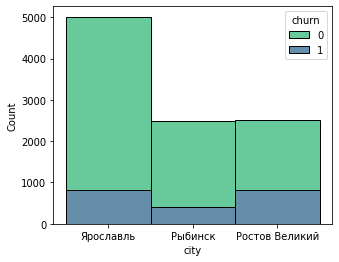

,Остались,Отток,"Процент оттока, %"
city,,,
Ростов Великий,1695,814,32.4
Рыбинск,2064,413,16.7
Ярославль,4204,810,16.2


In [22]:
function_parametrs ('city')

Ростов Великий - лидер по проценту оттока, 32% клиентов жителей этого города ушли из банка. Остальные города имеют по 16% оттока.

**Гендер**

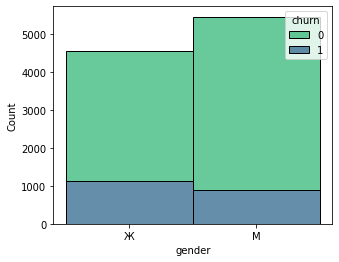

,Остались,Отток,"Процент оттока, %"
gender,,,
Ж,3404,1139,25.1
М,4559,898,16.5


In [23]:
function_parametrs ('gender')

Четверть женщин уходят из банка, мужчин в оттоке в 1,5 раза меньше - 16%.

**Объекты в собственности**

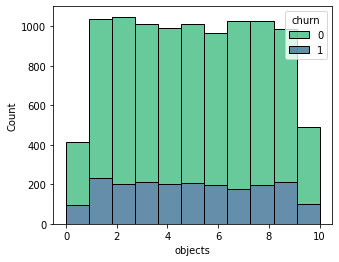

,Остались,Отток,"Процент оттока, %"
objects,,,
0,318,95,23.0
1,803,232,22.4
2,847,201,19.2
3,796,213,21.1
4,786,203,20.5
5,803,209,20.7
6,771,196,20.3
7,851,177,17.2
8,828,197,19.2


In [24]:
function_parametrs ('objects')

Какой-то огромной разницы в долях разных объектов на графике не наблюдается. Есть провалы крайних значений по количеству, но это скорее всего можно отнести к выбросам. Вероятно, данный признак на отток никак не влияет.

**Продукты**

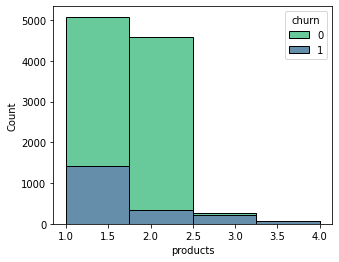

,Остались,Отток,"Процент оттока, %"
products,,,
1,3675.0,1409.0,27.7
2,4242.0,348.0,7.6
3,46.0,220.0,82.7
4,NaN,60.0,NaN


In [25]:
function_parametrs ('products')

Подтверждается предположение о неравномерности долей по продуктам:
- с 4-мя продуктами ушли все клиенты, 
- с 3-мя ушли почти все - 83%,
- с 1-м продуктом - почти 30% в оттоке,
- лучше всего ситуация в двух продуктах - отток всего чуть более 7%.

**Кредитные карты**

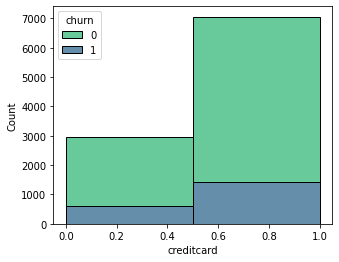

,Остались,Отток,"Процент оттока, %"
creditcard,,,
0,2332,613,20.8
1,5631,1424,20.2


In [26]:
function_parametrs ('creditcard')

Доли оттока двух групп (с кредитками и без) практически равны. Наличие или отсутствие кредитной карты никак не влияет на отток. 

**Активность клиента**

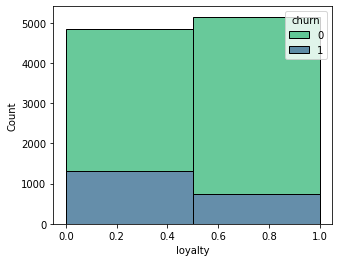

,Остались,Отток,"Процент оттока, %"
loyalty,,,
0,3547,1302,26.9
1,4416,735,14.3


In [27]:
function_parametrs ('loyalty')

Доля ушедших неактивных клиентов - 27%, доля активных в оттоке в два раза меньше -14%.

**Возраст**

Посмотрим на плотность распределения двух групп клиентов в разбивке по возрасту.

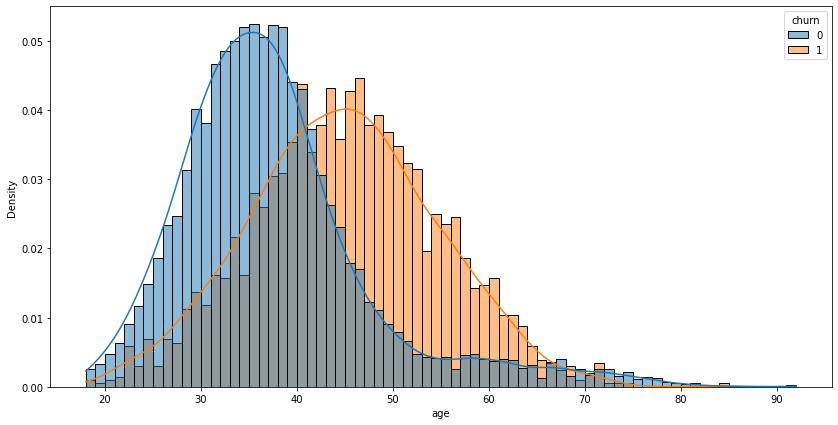

In [28]:
f, ax = plt.subplots(figsize=(14, 7))

sns.histplot(x='age',
             stat="density",
             bins=data['age'].max()-data['age'].min(),
             common_norm=False,
             data=data,
             hue = 'churn',
             kde=True)
plt.show()

Видим, что пик оставшихся клиентов по отношению к ушедшим приходится в районе 35-36 лет, кривые двух распределений первый раз пересекаются в районе 40-41 года и вплоть до 65-67 лет первенство удерживает доля клиентов в оттоке.

Посмотрим на процент оттока по каждому возрасту.

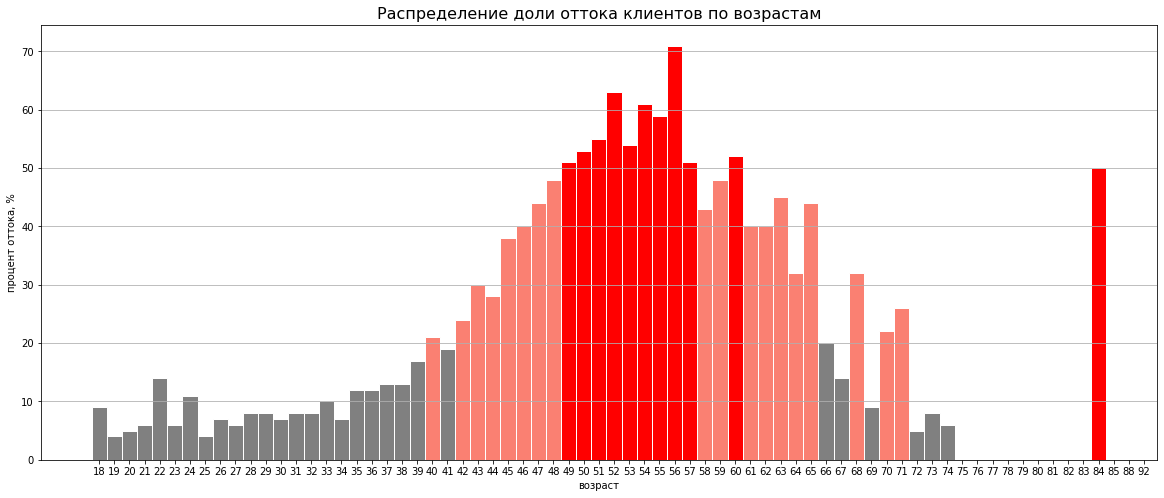

In [29]:
# создадим переменную с расчетом долей оттока по возрастам
data_age = data.pivot_table(index='age', columns='churn', aggfunc={'userid':'count'})
data_age.columns = ['Остались', 'Отток']
data_age['Процент оттока'] = (data_age['Отток'] / (data_age['Остались'] + data_age['Отток'])*100).round()
data_age = data_age.reset_index()

x = data_age.index.to_list()
y = data_age['Процент оттока'].tolist() 
 
names = data_age['age'].tolist()
barWidth = 1
# сформируем график
plt.figure(figsize=(20,8))
p1 = plt.bar(x, y, color='grey', edgecolor='white', width=barWidth)

# подсветим бары разными цветами, более 20% и более 50% оттока
for patch in p1.patches:
    if patch.get_height() >= 50.0:
        patch.set_facecolor('red')
    elif patch.get_height() > 20.0 and patch.get_height() < 50:
        patch.set_facecolor('salmon')


plt.xticks(x, names)
plt.title('Распределение доли оттока клиентов по возрастам', fontsize = 16)
plt.xlabel("возраст")
plt.ylabel("процент оттока, %")
plt.grid(axis = 'y')
plt.show()


Резкий рост процента оттока наблюдается у клиентов, начиная от 40 лет и заканчивая 65 годами. Доля оттока в этой группе возрастов превышает 20%, от 49 до 57 лет доля превышает 50%. Пик в 50% в значении 84 лет является выбросом, учитывать этот фактор не будем.

**Кредитные баллы**

Посмотрим на плотность распределения двух групп клиентов

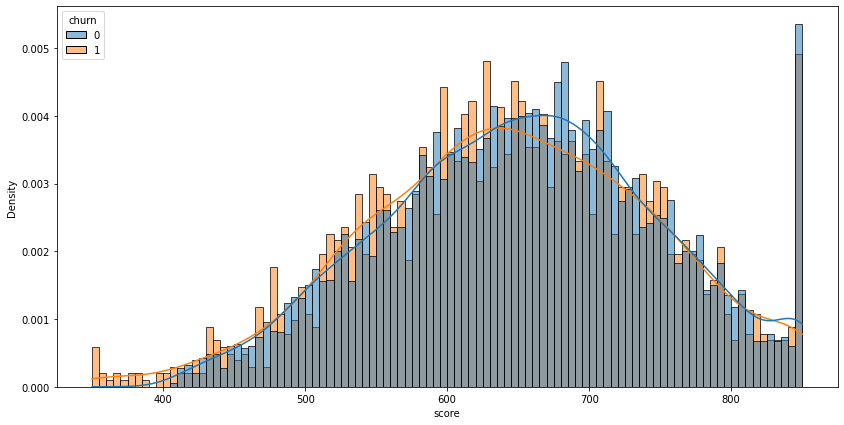

In [30]:
f, ax = plt.subplots(figsize=(14, 7))

sns.histplot(x='score',
             stat="density",
             bins=100,
             common_norm=False,
             data=data,
             kde = True,
             hue = 'churn')
plt.show()

Распределение имеет количественный всплеск на максимальных значениях баллов

Из графика видим аномально высокий кредитный балл. Аномалия ли это, баг, либо клиенты действительно заработали высокие быллы? Это должны проверить специалисты банка. А так как доля клиентов в оттоке схожа с долями остальных значений графика, акцентировать внимание на этом показателе не будем. Наличие низкого либо высокого кредитного балла на динамику оттока не влияет.

**Доходы**

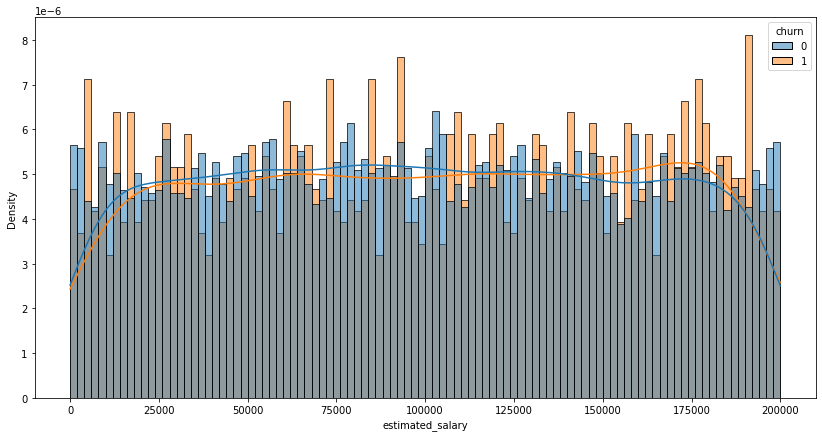

In [31]:
f, ax = plt.subplots(figsize=(14, 7))

sns.histplot(x='estimated_salary',
             stat="density",
             bins=100,
             common_norm=False,
             data=data,
             kde = True,
             hue = 'churn')
plt.show()

Никакой зависимости оттока относительно доходов клиентов на графике не обнаружено, клиенты с разными доходами уходят в отток одинаково.

**Баланс**

Ранее мы уже рассмотрели зависимость оттока от баланса и пришли к заключению, что величина баланса не влияет на долю оттока.

**Построим матрицу корреляций**

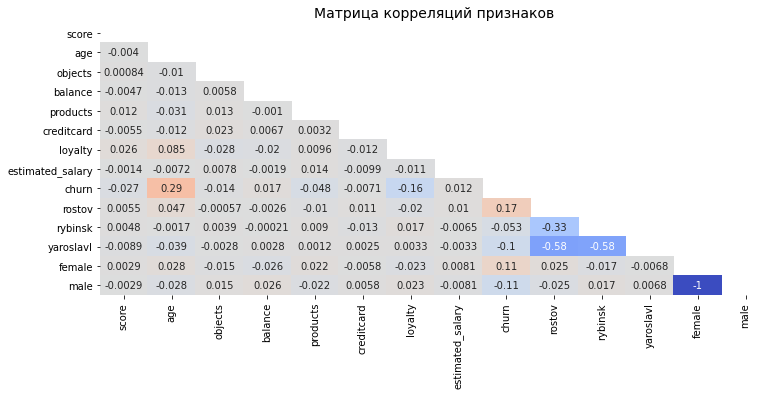

In [32]:
fig, ax = plt.subplots(figsize=(12, 5))
matrix = np.triu(data.drop('userid', axis=1).corr())
sns.heatmap(data.drop('userid', axis=1).corr()
            , annot = True
            , mask=matrix
            , fmt='.2g'
            , vmin=-1
            , vmax=1
            , center= 0
            , cmap= 'coolwarm'
            , cbar=False)
plt.title('Матрица корреляций признаков', fontsize = 14)
plt.show()

Коррелирующие признаки:
- возраст,
- город Ростов Великий,
- женский пол

Все остальные параметры почти в нулях.

**Выводы исследовательского анализа**

Параметры влияющие на отток:
- **город** - в Ростове Великом процент оттока 32% клиентов, остальные города - по 16% оттока;
- **гендер** - женщины уходят в 1,5 раза активнее мужчин;
- **продукты** - с 4-мя продуктами ушли все клиенты, с 3-мя - 83%, с 1-м продуктом - 30%, с 2-мя - 7%;
- **лояльность** - неактивные клиенты уходят из банка в 2 раза чаще активных;
- **возраст** - от 40 до 65 лет наблюдается резкий рост доли оттока, более 20%, на пике (49-57 лет) превышает 50%.

Параметры не влияющие на отток: 

количество объектов в собственности, наличие или отсутствие кредитной карты, значение кредитного балла, доход, баланс.

### Сегментация клиентов по группам

Для сегментации выборки у нас есть несколько признаков, влияющих на отток, которые были выявлены в ходе исследовательского анализа:
- возраст клиента,
- количество продуктов,
- город проживания

**Начнем с возрастных групп**

Разделим данные на три группы: молодые (до 30 лет), средний возраст (от 30 до 50 лет) и пожилые (старше 50 лет).

In [33]:
def age_group(age): #создадим функцию
    if age < 40:   #зададим условия
        return 'молодой'
    if age >= 40 and age <= 65:
        return 'средний'
    else:
        return 'пожилой'
#добавим столбец, в который наша функция вернет категории по значению возраста клиентов  
data['age_group'] = data['age'].apply(age_group) 
data.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан,0,0,1,1,0,средний
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан,0,1,0,1,0,средний
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,указан,0,0,1,1,0,средний
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,не указан,0,0,1,1,0,молодой
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,указан,0,1,0,1,0,средний


Посмотрим на доли оттока по возрастным группам

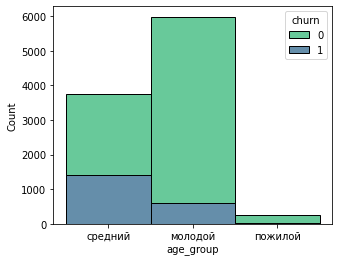

,Остались,Отток,"Процент оттока, %"
age_group,,,
молодой,5390,597,10.0
пожилой,229,35,13.3
средний,2344,1405,37.5


In [34]:
function_parametrs ('age_group')

В оттоке:
- клиенты среднего возраста (от 40 до 65 лет) - **37,5%**,
- пожилые (старше 65 лет) - **13%**,
- молодые (младше 40 лет) - **10%**

**Вторая сегментация - по количеству продуктов**

Создадим три группы по количеству продукта

In [36]:
def products_group(products): #создадим функцию
    if products == 1:   #зададим условия
        return '1 продукт'
    if products == 2:
        return '2 продукта'
    else:
        return '3-4 продукта'
#добавим столбец, в который наша функция вернет категории по значению кол-ва продукта  
data['products_group'] = data['products'].apply(products_group) 
data.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group,products_group
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан,0,0,1,1,0,средний,1 продукт
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан,0,1,0,1,0,средний,1 продукт
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,указан,0,0,1,1,0,средний,3-4 продукта
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,не указан,0,0,1,1,0,молодой,2 продукта
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,указан,0,1,0,1,0,средний,1 продукт


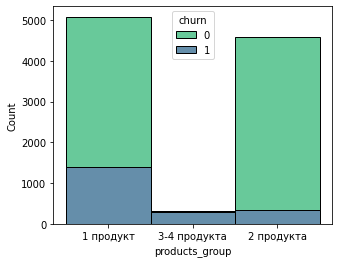

,Остались,Отток,"Процент оттока, %"
products_group,,,
1 продукт,3675,1409,27.7
2 продукта,4242,348,7.6
3-4 продукта,46,280,85.9


In [37]:
function_parametrs ('products_group')

Наличие более 2-х продуктов у клиента приводит к гарантированному оттоку, 86% таких клиентов ушли.
Наличие только одного продукта у клиента также приводит к риску его оттока, 27,7% клиентов покинули банк.

**Рассмотрим пересечение сегментов по возрасту и количеству продуктов**

In [38]:
# используем предыдущую функцию, добавив аргумент data
def function_twin_parametrs (column, data):

    plt.figure(figsize=(5,4))
    bins=data[column].unique().__len__()
    sns.histplot(x=column
                 , bins=bins
                 , data=data
                 , multiple="stack"
                 , hue = 'churn'
                 , palette = 'inferno')
    plt.show()
    
    data_table = data.pivot_table(index=column, columns='churn', aggfunc={'userid':'count'})

    data_table.columns = ['Остались', 'Отток']

    data_table['Процент, %'] = (data_table['Отток'] / (data_table['Остались'] + data_table['Отток'])*100).round(1)
    display(data_table)
    

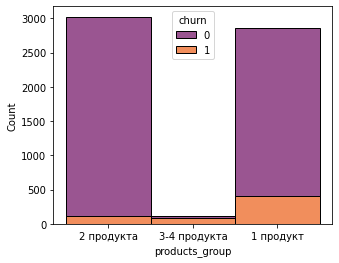

,Остались,Отток,"Процент, %"
products_group,,,
1 продукт,2452,401,14.1
2 продукта,2907,116,3.8
3-4 продукта,31,80,72.1


In [39]:
function_twin_parametrs ('products_group', data.query('age_group == "молодой"'))

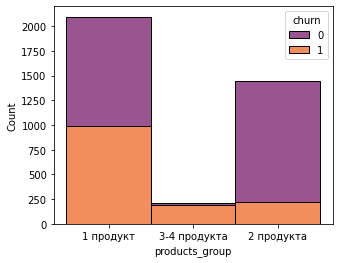

,Остались,Отток,"Процент, %"
products_group,,,
1 продукт,1110,986,47.0
2 продукта,1223,223,15.4
3-4 продукта,11,196,94.7


In [40]:
function_twin_parametrs ('products_group', data.query('age_group == "средний"'))

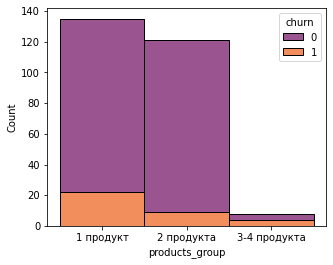

,Остались,Отток,"Процент, %"
products_group,,,
1 продукт,113,22,16.3
2 продукта,112,9,7.4
3-4 продукта,4,4,50.0


In [41]:
function_twin_parametrs ('products_group', data.query('age_group == "пожилой"'))

Максимальный отток в любом возрасте имеет группа клиентов, пользующихся 3-4 продуктами от 50% среди пожилых, до 95% среди средневозрастных. 

Так же стоит обратить внимание на группу людей с 1-м продуктом. Почти половина клиентов среднего возраста (от 40 до 65 лет) ушла в отток - это около 1000 клиентов. 

Специалистам банка стоит обратить внимание на данные группы клиентов и продукты, которыми они пользуются, так как оптимальнее всего для лояльного пользования услугами банка для клиентов любых возрастных групп является наличие именно двух продуктов в пользовании.

***Рассмотрим пересечение сегментов по городу и возрасту***

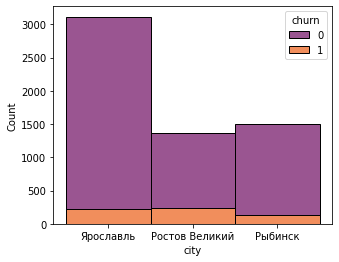

,Остались,Отток,"Процент, %"
city,,,
Ростов Великий,1134,235,17.2
Рыбинск,1368,134,8.9
Ярославль,2888,228,7.3


In [42]:
function_twin_parametrs ('city', data.query('age_group == "молодой"'))

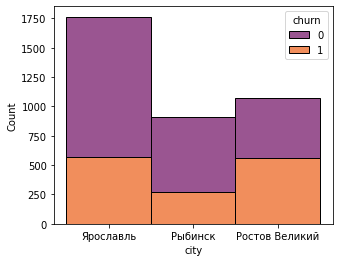

,Остались,Отток,"Процент, %"
city,,,
Ростов Великий,513,563,52.3
Рыбинск,636,272,30.0
Ярославль,1195,570,32.3


In [43]:
function_twin_parametrs ('city', data.query('age_group == "средний"'))

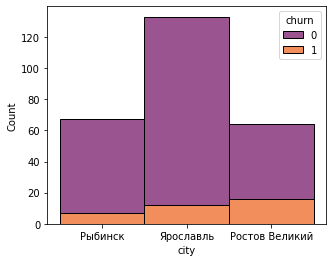

,Остались,Отток,"Процент, %"
city,,,
Ростов Великий,48,16,25.0
Рыбинск,60,7,10.4
Ярославль,121,12,9.0


In [44]:
function_twin_parametrs ('city', data.query('age_group == "пожилой"'))

Половина клиентов среднего возраста из Ростова ушла в отток, из остальных городов - по 30% в оттоке.
Клиенты других возрастных групп показывают такое же деление по городам - В Ростове Великом доля оттока превышает показатель других городов в 2-2,5 раза.

**Посмотрим на лояльность в городах**

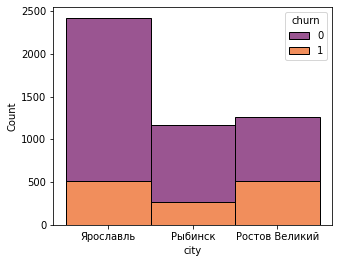

,Остались,Отток,"Процент, %"
city,,,
Ростов Великий,743,518,41.1
Рыбинск,893,272,23.3
Ярославль,1911,512,21.1


In [45]:
function_twin_parametrs ('city', data.query('loyalty == 0'))

Около 40% ушедших клиентов из Ростова Великого были нелояльны к банку. С чем это связано? Как ранее мы выяснили, из этого города нет клиентов с пропущенным балансов в данных. Есть предположения, что в данном региональном подразделении банка, лиюо произошли системные сбои, либо низкий сервис обслуживания клиентов, возможно даже симбиоз данных факторов. Требуется детальный разбор коммуникации сотрудников банка с данными клиентами.

**Итоговые подсчеты**

Расчитаем количество и долю от общего числа клиентов в оттоке по сегменту продуктов

Создадим функцию для вывода сводных таблиц клиентов в оттоке по сегментам с рачетом процента оттока от общего количества клиентов в выборке.

In [46]:
def user_count_parametrs (index, data):
    user_count = data.pivot_table(index=index, columns='churn', aggfunc={'userid':'count'})

    user_count.columns = ['Остались', 'Отток']

    user_count['Процент, %'] = (user_count['Отток'] / (user_count['Остались'] + user_count['Отток'])*100).round(1)
    display(user_count)

Посмотрим на долю оттока клиентов среднего возраста женского пола из Ростова Великого в разбивке по продуктам

In [47]:
user_count_parametrs ('products_group', data.query('age_group == "средний" & city == "Ростов Великий" & gender == "Ж"'))

,Остались,Отток,"Процент, %"
products_group,,,
1 продукт,111,210,65.4
2 продукта,128,52,28.9
3-4 продукта,2,37,94.9


210 клиентов (65% сегмента) из Ростова Великого возрастом от 40 до 65 лет, женского пола, которые пользуются только 1-м продуктом ушли в отток.

In [48]:
user_count_parametrs ('products_group', data.query('age_group == "средний" & city == "Ярославль" & gender == "Ж"'))

,Остались,Отток,"Процент, %"
products_group,,,
1 продукт,223,225,50.2
2 продукта,273,46,14.4
3-4 продукта,2,50,96.2


В Ярославле почти с тем же количеством клиентов сегментированной группы (225 человек) доля оттока в сегменте составляет 50%.

Определены параметры клиентов, влияющие на отток. Данные параметры рассмотрены в пересечении между собой, что позволило сегментировать и сузить портрет клиента до конкретных критериев.

Параметры сегментированной группы:
- город проживания - Ростов Великий и Ярославль,
- возраст от 40 лет и выше,
- женского пола,
- продуктов в пользовании - один или более двух.

In [49]:
print('количество клиентов в группе:', data.query('age_group != "молодой" \
            & city != "Рыбинск" \
            & gender != "М" \
            & products_group != "2 продукта"')['userid'].nunique())
print('количество клиентов в оттоке:', data.query('age_group != "молодой" \
            & city != "Рыбинск" \
            & gender != "М" \
            & products_group != "2 продукта" \
            & churn == 1')['userid'].nunique())
print('процент оттока:', round(data.query('age_group != "молодой" \
            & city != "Рыбинск" \
            & gender != "М" \
            & products_group != "2 продукта" \
            & churn == 1')['userid'].nunique()/
            data.query('age_group != "молодой" \
            & city != "Рыбинск" \
            & gender != "М" \
            & products_group != "2 продукта"')['userid'].nunique()*100), '%')

количество клиентов в группе: 909
количество клиентов в оттоке: 537
процент оттока: 59 %


**Выводы:**

*Портрет клиента, склонного к оттоку:*
- возраст от 40 лет и выше (доля среди пожилых клиентов высокая)
- пользуется одним или более 2-мя продуктами банка,
- снижение лояльности к банку,
- проживание в Ростове Великом либо в Ярославле,
- преимущественно женского пола.

*Портрет лояльного клиента:*
- молодой (до 40 лет),
- пользуется 2-мя продуктами банка,
- преимущественно мужского пола,
- проживает в Рыбинске или Ярославле.

## Этап 5. Проверка гипотез

**Гипотезы:**
- Средние доходы между клиентами, которые ушли и теми, которые остались одинаковые
- Среднее значение баллов кредитного скорринга клиентов из Ростова Великого, которые ушли и которые остались одинаковое

Для проверки гипотез используем специальный метод о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.
Необходимые требования к выборкам для использования данного метода:
 - Выборки большого объема (более 30 значений в каждой совокупности),
 - Генеральные совокупности не должны зависеть друг от друга,
 - Выборочные средние должны быть нормально распределены,
 - Дисперсии рассматриваемых генеральных совокупностей должны быть равны.

Для проверки первой гипотезы у нас соблюдены требования к данным:
- Более 30 значений в каждой выборке,
- данные не зависят друг от друга (в каждой группе "отток" и "неотток" свои уникальные клиенты),
- исходя из графика плотность нормального распределения двух выборок распределены практически нормально.
- в тесте параметр *equal_var* отвечает за равность дисперсий, если дисперсии не равны,  значение =  False (метод Уэлча). значения 

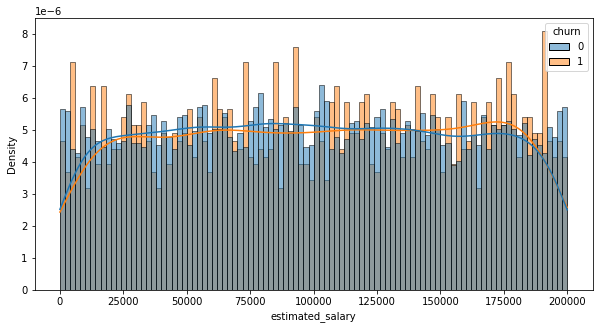

In [51]:
f, ax = plt.subplots(figsize=(10, 5))

sns.histplot(x='estimated_salary',
             stat="density",
             bins=100,
             common_norm=False,
             data=data,
             kde = True,
             hue = 'churn')
plt.show()

Для проверки второй гипотезы у нас соблюдены не все требования к данным:
- Более 30 значений в каждой выборке,
- данные так же не зависят друг от друга,
- на графике виден выброс значений, потребуется его удаление перед проведением теста.
- с дисперсиями тот же способ, что и с первой гипотезой.

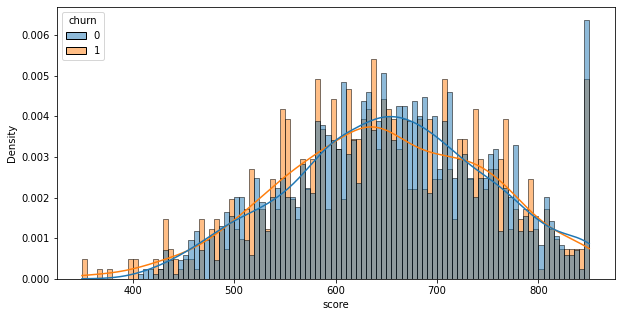

In [52]:
f, ax = plt.subplots(figsize=(10, 5))

sns.histplot(x='score',
             stat="density",
             bins=100,
             common_norm=False,
             data=data.query('city == "Ростов Великий"'),
             kde = True,
             hue = 'churn')
plt.show()

#### 5.1. Средние доходы между клиентами, которые ушли и теми, которые остались одинаковые

Сформулируем основную и альтернативную гипотезы:
* H₀ - средние значения дохода клиентов, которые ушли и теми, которые остались равны
* H₁ - средние значения дохода клиентов, которые ушли и теми, которые остались не равны

Создадим две переменные и сохраним в них срезы по оттоку

In [53]:
# Переменная со срезом оставшихся клиентов
data_not_churn = data.query('churn == 0')
data_not_churn.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group,products_group
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,указан,0,1,0,1,0,средний,1 продукт
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,не указан,0,0,1,1,0,молодой,2 продукта
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,указан,0,1,0,1,0,средний,1 продукт
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0,не указан,0,0,1,0,1,средний,2 продукта
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0,указан,0,0,1,0,1,средний,2 продукта


In [54]:
# Переменная со срезом клиентов в оттоке
data_churn = data.query('churn == 1')
data_churn.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group,products_group
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,не указан,0,0,1,1,0,средний,1 продукт
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,указан,0,0,1,1,0,средний,3-4 продукта
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1,указан,0,1,0,0,1,средний,2 продукта
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1,указан,1,0,0,1,0,молодой,3-4 продукта
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,1,0,5097.67,1,указан,1,0,0,0,1,средний,1 продукт


Посмотрим на величину дисперсий выборок

In [55]:
np.var(data_not_churn['estimated_salary']), np.var(data_churn['estimated_salary'])

(3294987575.73531, 3352201702.316679)

Дисперсии различаются, применим метод Уэлча (equal_var = False)

In [56]:
#специальным методом проверим гипотезу о равенстве среднего двух генеральных совокупностей
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(
    data_not_churn['estimated_salary'], 
    data_churn['estimated_salary'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22892461305145798
Не получилось отвергнуть нулевую гипотезу


Вероятность получить равнозначность средних значений в двух выборках = 22%
Нулевая гипотеза вероятна.

In [57]:
print('Средний доход оставшихся клиентов:', round(data_not_churn['estimated_salary'].mean()))
print('Средняя доход клиентов в оттоке  :', round(data_churn['estimated_salary'].mean()))

Средний доход оставшихся клиентов: 99738
Средняя доход клиентов в оттоке  : 101466


Подтверждение данной нулевой гипотезы говорит нам о том, что уровень дохода не влияет на вероятность оттока клиентов.

**5.2. Среднее значение баллов кредитного скорринга клиентов из Ростова Великого, которые ушли и которые остались одинаковое**

Сформулируем основную и альтернативную гипотезы:
* H₀ - Среднее значение баллов кредитного скорринга клиентов из Ростова Великого, которые ушли и которые остались равно
* H₁ - Среднее значение баллов кредитного скорринга клиентов из Ростова Великого, которые ушли и которые остались не равно

Посмотрим на процент выбросов.

In [58]:
np.percentile(data['score'], [90, 95, 99])

array([778., 812., 850.])

1% данных - аномалия, исключим эти данные при проведении теста.

Создадим две переменные и сохраним в них срезы по оттоку и городам

In [59]:
# Переменная со срезом оставшихся клиентов из Ростова Великого
data_rostov_on = data.query('city == "Ростов Великий" & churn == 0 & score < 850')
data_rostov_on.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group,products_group
15,15686702,616,Ростов Великий,М,45,3,143129.41,2,0,1,64327.26,0,указан,1,0,0,0,1,средний,2 продукта
26,15779552,756,Ростов Великий,М,36,2,136815.64,1,1,1,170041.95,0,указан,1,0,0,0,1,молодой,1 продукт
28,15771429,574,Ростов Великий,Ж,43,3,141349.43,1,1,1,100187.43,0,указан,1,0,0,1,0,средний,1 продукт
32,15792917,553,Ростов Великий,М,41,9,110112.54,2,0,0,81898.81,0,указан,1,0,0,0,1,средний,2 продукта
39,15628504,582,Ростов Великий,М,41,6,70349.48,2,0,1,178074.04,0,указан,1,0,0,0,1,средний,2 продукта


In [60]:
# Переменная со срезом клиентов в оттоке из Ростова Великого
data_rostov_off = data.query('city == "Ростов Великий" & churn == 1 & score < 850')
data_rostov_off.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,balance_copy,rostov,rybinsk,yaroslavl,female,male,age_group,products_group
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1,указан,1,0,0,1,0,молодой,3-4 продукта
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,1,0,5097.67,1,указан,1,0,0,0,1,средний,1 продукт
46,15645016,829,Ростов Великий,Ж,27,9,112045.67,1,1,1,119708.21,1,указан,1,0,0,1,0,молодой,1 продукт
47,15814309,637,Ростов Великий,Ж,39,9,137843.80,1,1,1,117622.80,1,указан,1,0,0,1,0,молодой,1 продукт
53,15745034,655,Ростов Великий,М,41,8,125561.97,1,0,0,164040.94,1,указан,1,0,0,0,1,средний,1 продукт


Посмотрим на величину дисперсий выборок

In [61]:
np.var(data_not_churn['score']), np.var(data_churn['score'])

(9148.507520552681, 10059.463096678073)

Дисперсии выборок различаются

In [62]:
#специальным методом проверим гипотезу о равенстве среднего двух генеральных совокупностей
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(
    data_rostov_on['score'], 
    data_rostov_off['score'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.272076658796686
Не получилось отвергнуть нулевую гипотезу


Вероятность получить равнозначность средних значений в двух выборках = 27 %
Нулевая гипотеза вероятна.

In [63]:
print('Среднее значение баллов оставшихся клиентов из Ростова Великого:', round(data_rostov_on['score'].mean()))
print('Среднее значение баллов клиентов в оттоке из Ростова Великого:', round(data_rostov_off['score'].mean()))

Среднее значение баллов оставшихся клиентов из Ростова Великого: 648
Среднее значение баллов клиентов в оттоке из Ростова Великого: 643


Средние значения кредитных баллов клиентов в Ростове Великом (в котором выявили повышенный отток) практически равны, это означает, что данные параметр на отток клиентов не влияет 

## Этап 6. Выводы и рекомендации

Анализ данных показал, что из 10000 клиентов банка, 20% отказались от его услуг.

**Основные признаки оттока:**
    
 - *недостаточное либо большое количество предлагаемых продуктов*

Выявлено, что 2 продукта в пользовании является оптимальным количеством для клиента. 17% с другим количеством продукта в оттоке.

  - *возраст клиентов, чем выше возраст клиента, тем динамика оттока увеличивается*

20 % среди клиентов среднего возраста (от 30 до 50 лет) перестали сотрудничество с банком. Среди пожилых клиентов (старше 50 лет) данный показатель составляет почти 50%.
Молодежь (30 лет и моложе) уходит реже, всего 7,5%.

  - *город проживания*

Ростов Великий - лидер по оттоку, доля ушедших клиентов жителей города - 30%. Ярославль с таким же количеством клиентов в оттоке имеет меньшую долю - 16%.

**Предположительные причины оттока**

- Пользуясь одним продуктом (например только зарплатной картой), клиент, не зная о других возможностях, теряет интерес к банку. И наоборот, имея в пользовании 3-4 продукта в пользовании, клиент "устаёт" от переизбытка навязанных услуг, что тоже снижает лояльность к банку.

- Средний возраст клиента в оттоке - 45 лет. Пожилые люди уходят из банка активнее молодых. Причиной этому может быть цифровизация процессов и услуг банка, внедрение пользования банковским приложением либо личным кабинетом онлайн.
К сожалению, так сложилось, что более возрастные, а тем более пожилые люди имеют низкий опыт и навыки пользования онлайн услугами. По привычке люди такой возрастной категории привыкли вживую коммуницировать с банком, поэтому они не успевают адаптировать к онлайн среде.


- Лидер по доле оттока - Ростов Великий. Причину необходимо искать в качестве предоставления услуг в отделениях банка этого города. Возможно произошла ротация кадров, что повлияло на обслуживании клиентов. Либо произошел системный сбой банковских данных, который вызвал рост негодования клиентов.

**Рекомендации сотрудникам банка:**

1) Диверсифицировать количество предлагаемых продуктов:
* клиентам с одним - предложить дополнительно ещё: открытие дополнительного накопительного вклада, кредитная карта на льготных условиях.
* Клиентам с 3-4 продуктами предложить сократить количество без потери качества услуг, например закрытие неиспользуемых счетов, закрытие кредитов на выгодных условиях.

2) Провести рекламную кампанию:

  * для привлечения молодых клиентов (самые перспективные).
  * провести ликбез по обучению пожилых клиентов онлайн услуг, модернизация (оптимизация) онлайн услуг.

3) Проверить качество предоставляемых услуг в отделениях банка в Ростове Великом.